In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

#Prepare the data.
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from numpy import linalg as LA

dtype = torch.FloatTensor

images = np.load("../data/images.npy")
labels = np.load("../data/labels.npy")

images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))

images = images - images.mean()
images = images/images.std() 

train_seqs = images[0:40000]
val_seqs = images[40000:50000]

train_labels = labels[0:40000]
cv_labels = labels[40000:50000]

In [3]:
def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

import random

#approx train accuracy() that extracts 1,000 random training
#instances, creates a single batch with all of these inputs, computes integer predictions
#for each example in the batch, and returns an accuracy by comparing these
#predictions to the ground-truth labels. 

def approx_train_accuracy():
    model.eval()
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)
    return acc


#val accuracy() that creates a single batch with all validation
#examples, computes integer predictions for each example in the batch, and returns
#an accuracy by comparing these predictions to the ground-truth labels.

def val_accuracy():
    model.eval()
    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int) 
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)

    return acc


In [6]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class MaxPerformanceCNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1)
        
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        
        self.final_conv = torch.nn.Conv2d(64,5, kernel_size=1)
        
    
    def forward(self, x):
        
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        n, c, h, w = x.size()
        x = F.max_pool2d(x, kernel_size=[h,w])
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        
        return x
        

model = MaxPerformanceCNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    #loss = F.nll_loss(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_accs, val_accs = [], []
batch_size = 300
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.20  0.22
   100  0.88  0.89
   200  0.91  0.90
   300  0.91  0.90
   400  0.91  0.92
   500  0.93  0.94
   600  0.92  0.93
   700  0.94  0.92
   800  0.93  0.92
   900  0.92  0.92
  1000  0.93  0.93
  1100  0.95  0.93
  1200  0.93  0.93
  1300  0.94  0.94
  1400  0.92  0.92
  1500  0.95  0.93
  1600  0.93  0.94
  1700  0.93  0.94
  1800  0.93  0.93
  1900  0.94  0.92
  2000  0.95  0.93
  2100  0.94  0.94
  2200  0.92  0.93
  2300  0.94  0.94
  2400  0.93  0.93
  2500  0.94  0.93
  2600  0.93  0.94
  2700  0.95  0.93
  2800  0.95  0.94
  2900  0.93  0.93
  3000  0.95  0.93
  3100  0.94  0.93
  3200  0.94  0.94
  3300  0.94  0.94
  3400  0.95  0.94
  3500  0.94  0.93
  3600  0.94  0.95
  3700  0.95  0.93
  3800  0.95  0.94
  3900  0.96  0.93
  4000  0.94  0.94
  4100  0.94  0.93
  4200  0.95  0.94
  4300  0.95  0.93
  4400  0.96  0.94
  4500  0.95  0.94
  4600  0.93  0.93
  4700  0.95  0.93
  4800  0.94  0.93
  4900  0.95  0.94


max_train accuracy:  0.96
max_val accuracy:  0.948


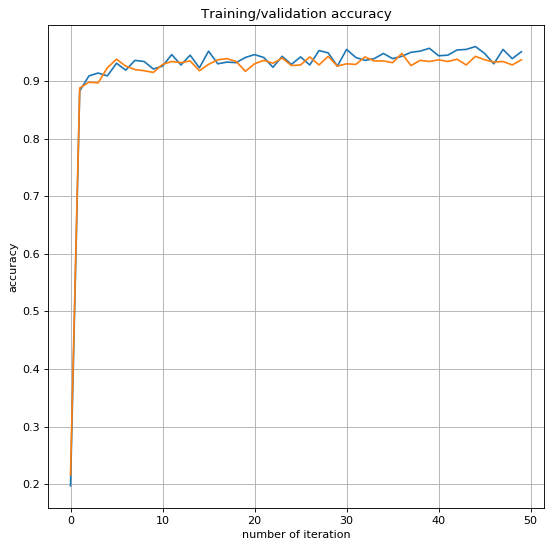

In [7]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Experimenting with batch normalization.

Normalising the ouput of convolutional layers using batchnorm2d()

In [4]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class MaxPerformanceCNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.batchNorm1 = torch.nn.BatchNorm2d(16)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.batchNorm2 = torch.nn.BatchNorm2d(32)
        
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.batchNorm3 = torch.nn.BatchNorm2d(64)
        
        self.final_conv = torch.nn.Conv2d(64,5, kernel_size=1)
        
    
    def forward(self, x):
        
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        #x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.dropout(x)
        
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #x = F.dropout(x)
        
        x = self.conv3(x)
        x = self.batchNorm3(x)
        n, c, h, w = x.size()
        
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=[h,w])
        x = F.dropout(x)
        
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        
        return x
        

model = MaxPerformanceCNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    #loss = F.nll_loss(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_accs, val_accs = [], []
batch_size = 300
for i in range(6000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.22  0.20
   100  0.93  0.92
   200  0.93  0.93
   300  0.95  0.93
   400  0.95  0.94
   500  0.96  0.94
   600  0.95  0.92
   700  0.96  0.94
   800  0.94  0.93
   900  0.97  0.93
  1000  0.98  0.93
  1100  0.97  0.94
  1200  0.96  0.93
  1300  0.98  0.93
  1400  0.98  0.94
  1500  0.96  0.92
  1600  0.96  0.90
  1700  0.98  0.93
  1800  0.99  0.93
  1900  0.99  0.94
  2000  0.98  0.94
  2100  0.98  0.93
  2200  0.99  0.95
  2300  0.99  0.93
  2400  0.99  0.93
  2500  0.99  0.94
  2600  0.99  0.95
  2700  1.00  0.94
  2800  0.99  0.92
  2900  0.99  0.92
  3000  0.99  0.92
  3100  0.99  0.93
  3200  1.00  0.93
  3300  1.00  0.93
  3400  0.99  0.93
  3500  0.99  0.93
  3600  0.99  0.93
  3700  0.99  0.93
  3800  0.99  0.94
  3900  0.99  0.93
  4000  0.99  0.92
  4100  0.99  0.93
  4200  1.00  0.94
  4300  0.99  0.93
  4400  0.99  0.95
  4500  0.99  0.90
  4600  1.00  0.93
  4700  1.00  0.95
  4800  1.00  0.94
  4900  1.00  0.94
  5000  1.00  0.94
  5100  0.99  0.94
  5200  0.99

max_train accuracy:  0.999
max_val accuracy:  0.95


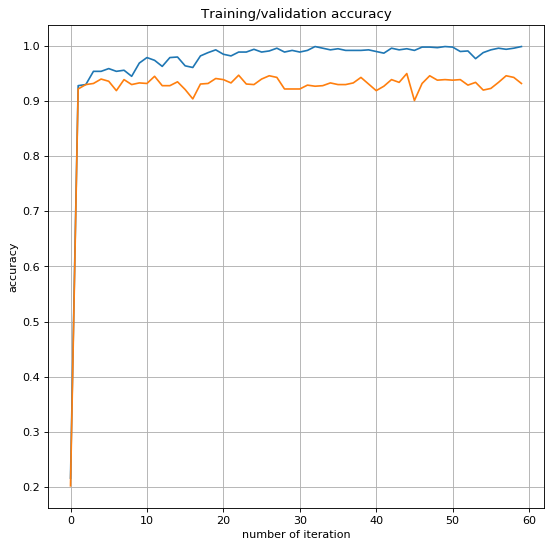

In [5]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Experimenting with Dropouts in various convlayers

In [6]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class MaxPerformanceCNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU()
            
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.final_conv = torch.nn.Conv2d(64,5, kernel_size=1)
        #self.fc = nn.Linear(64, 5)
        """
        self.transform = transforms.Compose([
            transforms.CenterCrop(10),
            transforms.ToTensor(),
            ])
        """
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.dropout(out, training=self.training)
        out = self.final_conv(out).view(-1, NUM_CLASSES)
        #print(out.size())
        #out = out.view(out.size(0), -1)
        #out = self.fc(out)
        return out
        

model = MaxPerformanceCNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_accs, val_accs = [], []
batch_size = 300
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.18  0.19
   100  0.92  0.91
   200  0.93  0.94
   300  0.93  0.93
   400  0.94  0.92
   500  0.94  0.92
   600  0.93  0.91
   700  0.95  0.94
   800  0.94  0.92
   900  0.95  0.94
  1000  0.96  0.93
  1100  0.96  0.93
  1200  0.95  0.93
  1300  0.96  0.93
  1400  0.96  0.93
  1500  0.96  0.94
  1600  0.97  0.94
  1700  0.96  0.94
  1800  0.96  0.92
  1900  0.96  0.94
  2000  0.96  0.94
  2100  0.95  0.95
  2200  0.96  0.93
  2300  0.97  0.95
  2400  0.96  0.95
  2500  0.96  0.94
  2600  0.97  0.94
  2700  0.97  0.94
  2800  0.97  0.94
  2900  0.97  0.94
  3000  0.97  0.95
  3100  0.98  0.94
  3200  0.97  0.96
  3300  0.97  0.92
  3400  0.97  0.95
  3500  0.98  0.94
  3600  0.98  0.94
  3700  0.97  0.94
  3800  0.97  0.93
  3900  0.97  0.94
  4000  0.97  0.93
  4100  0.97  0.95
  4200  0.97  0.93
  4300  0.98  0.95
  4400  0.98  0.94
  4500  0.97  0.94
  4600  0.97  0.94
  4700  0.98  0.95
  4800  0.98  0.94
  4900  0.98  0.94


max_train accuracy:  0.98
max_val accuracy:  0.958


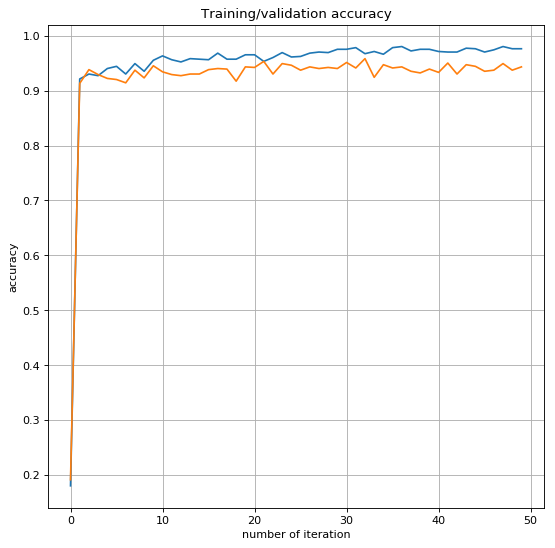

In [7]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Description of the Model:

Starting Point:

A simple CNN with 2 convolutional layer and 1 final $1X1$ convolution layer.
Used the following configuration:

    a. strides = 2 in both conv layer. 
    b. Learning rate = 0.001, 
    c. batch size = 300 and 
    d. opt steps = 5000
    e. Adam optimizer

# Performance Optimizations: Below are the steps followed to optimize the CNN to improve accuracy

    1. Used max_pooling instead of avg_pooling after applying the convolution step.
    2. Added 3rd convolution layer with relu activation and max pooling. Observed high overfitting but increased validation accuracy.
    3. Changed the strides in the 3rd convolution layer to 1. This increased the validation accuracy by 1%
    4. Included dropout before final convolution layer to reduce the overfitting trend.
    5. Changed the order of relu and maxpooling in the first two convolutional layers to increase two layers.

# Steps Tried but with negative impact on performance:

    1. Added 4th convolution layer only to reduce the validation accuracy significantly.
    2. Tried various loss function instead of Cross Entropy Loss. Not much change in accuracy.


# Final Accuracy Settings:

    1. 3 concolutional layer($3X3$) with relu and max pooling
    1. Adam optimizer
    2. Cross Entropy loss
    3. Batch size = 300
    4. Optimization steps: 5000
    5. Learning rate = 0.001
    
    Highest Validation accuracy = 96%




In [16]:
#Testing on kaggle data set.
#Generate a csv file with predictions.

#load the test data.
model.eval()
test_data = np.load("./data/part_2_test_images.npy")
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1]*test_data.shape[2]))

test_data = test_data - test_data.mean()
test_data = test_data/test_data.std() 

output = np.empty((5000, 2), dtype=np.uint0)
for i in range(test_data.shape[0]):
    x = Variable(torch.from_numpy(test_data[i].astype(np.float32)))
    out = model(x)
    label = np.argmax(out.data.numpy(), axis =1)
    output[i] = [i, label[0]]

np.savetxt('out_exp2.csv', output, delimiter=",",fmt='%1.0f', header="id,label")

# Failure Models

In [66]:
#identifying the 10 correct predictions and 10 incorrect predictions.

#run the model and check for predictions
correct = 0
incorrect = 0
model.eval()
index = 0
correct_predicted_input = []
incorrect_predicted_input = []
correct_labels = []
while(correct < 10 or incorrect < 10):
    x = Variable(torch.from_numpy(val_seqs[index].astype(np.float32)))
    y = train_labels[index].astype(np.int)
    
    out = model(x)
    y_hat = np.argmax(out.data.numpy(), axis =1)
    
    if ((y == y_hat) and (correct <10)) :
        correct += 1
        temp = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        correct_predicted_input.append(temp.data[0][0].numpy())
        correct_labels.append(y)
    elif ((y != y_hat) and (incorrect <10)) :
        incorrect += 1
        temp = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        incorrect_predicted_input.append(temp.data[0][0].numpy())
    
    index += 1

# Display correctly predicted images

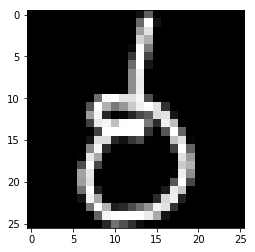

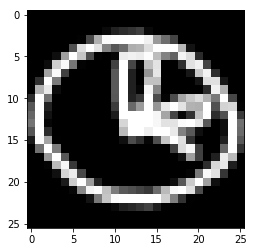

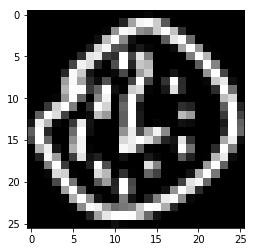

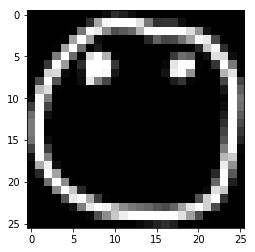

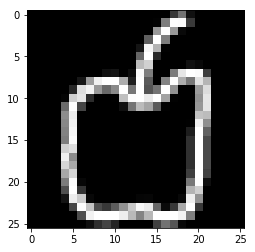

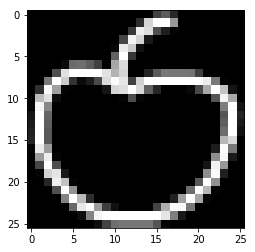

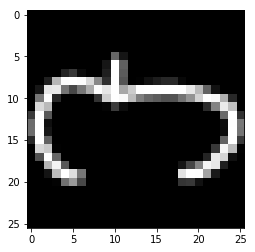

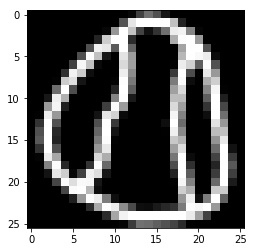

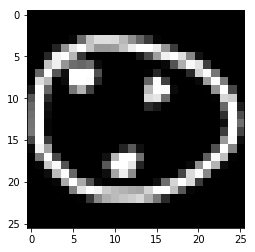

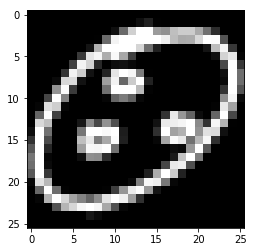

In [67]:
def display(image):
    plt.figure()
    plt.imshow(image)
    plt.set_cmap('gray')
for i in range(len(correct_predicted_input)):
    image = correct_predicted_input[i]
    display(image)

# Display incorrect Predictions:

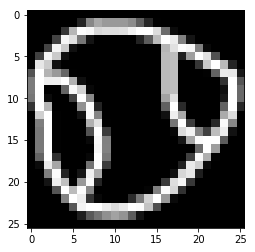

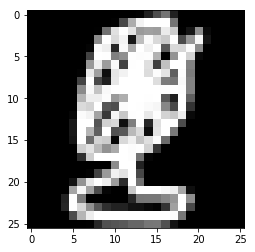

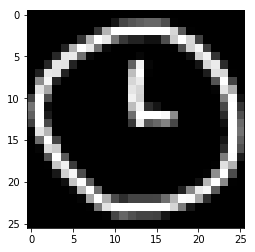

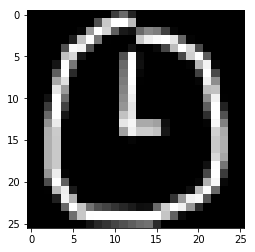

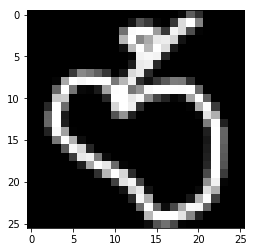

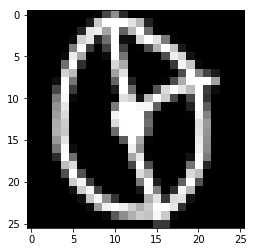

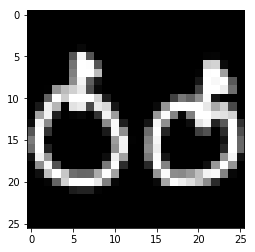

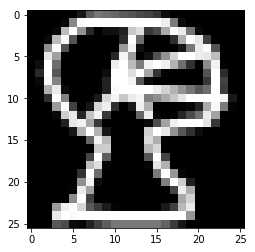

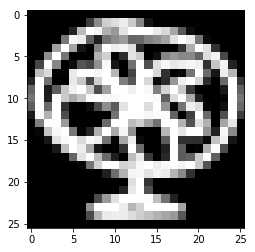

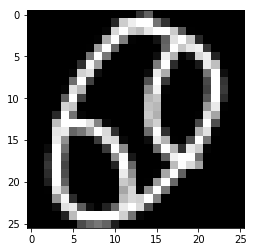

In [68]:
for i in range(len(incorrect_predicted_input)):
    image = incorrect_predicted_input[i]
    display(image)

# Differences between two correct and incorrect classifications:

    1. Some of incorrect classifications have multiple individual drawings in the same image.
    2. Some inccorect prediction have images with very closely highlighted regions.
    3. Most incorrect predictions have images which are tilted or rotated.

# Adding gaussian noise

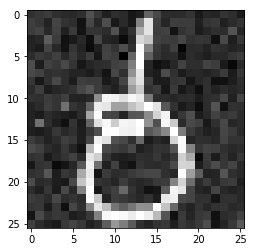

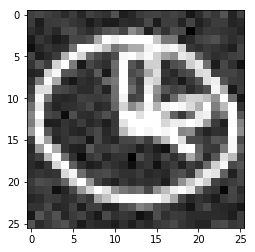

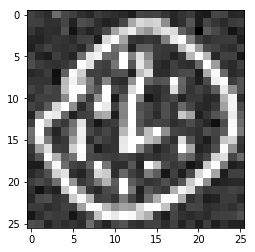

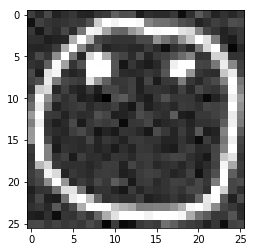

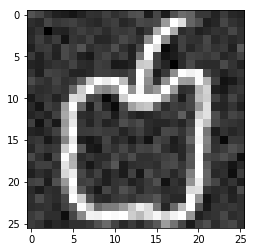

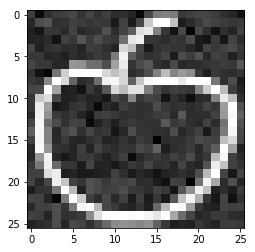

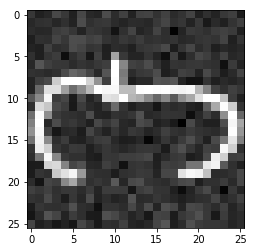

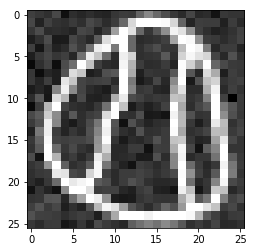

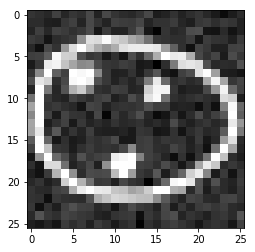

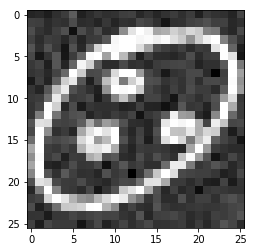

In [69]:
import skimage
gaussian_noise_images= []
for i in range(len(correct_predicted_input)):
    images = correct_predicted_input[i]
    images = images/images.max()
    new_image = skimage.util.random_noise(images, mode='gaussian')
    gaussian_noise_images.append(new_image)
    display(new_image)
